
📝 OCR Output Before Preprocessing:
----------------------------------------
Mile 84 utc
a ae ae eae
VC me ie ee
----------------------------------------

📝 OCR Output After Preprocessing:
----------------------------------------
hello MY biether
Thank You Fol Soar
cand effort and time
----------------------------------------


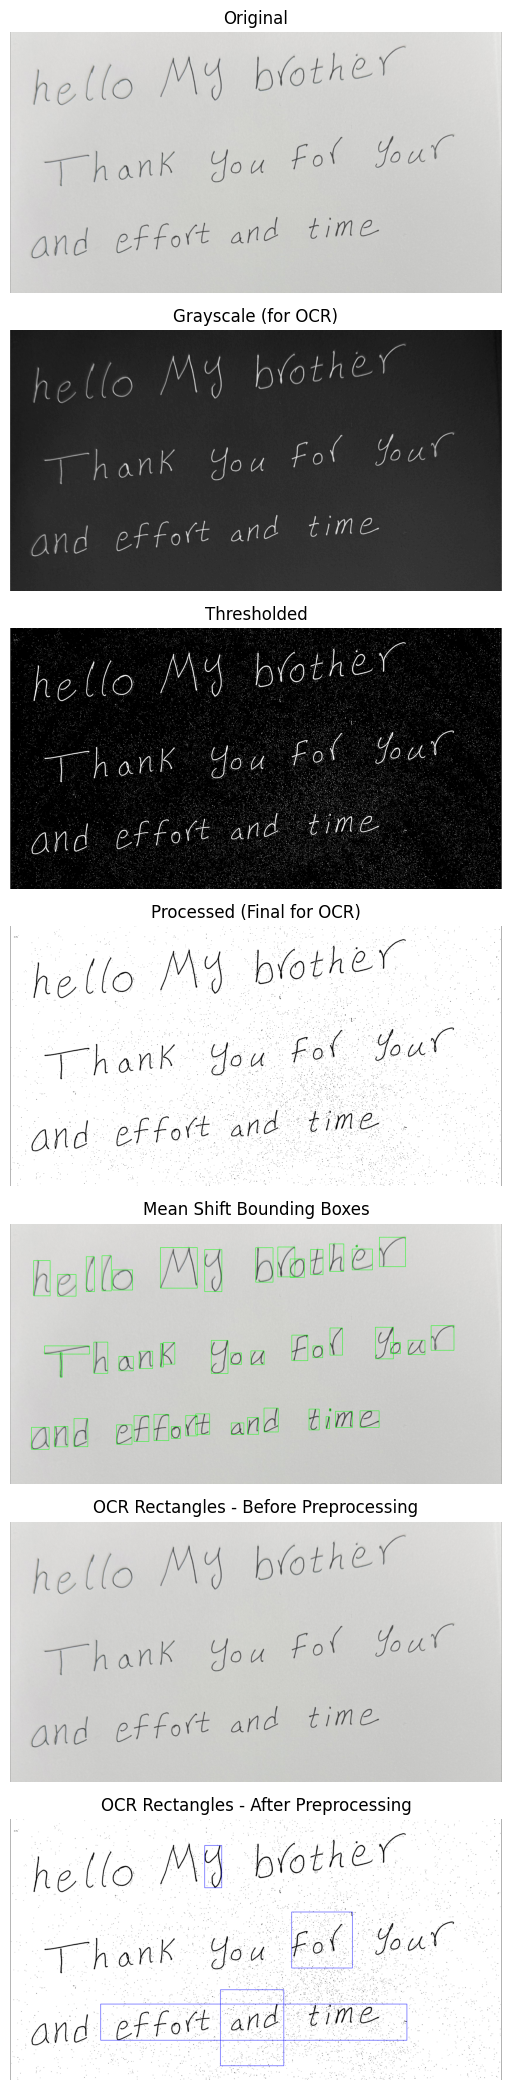

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from skimage.morphology import opening, closing, disk, ellipse, erosion
from pytesseract import Output

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found!")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.medianBlur(gray, 3)
    denoised = cv2.GaussianBlur(denoised, (5, 5), 0)

    # Contrast stretching
    min_val, max_val = np.min(denoised), np.max(denoised)
    stretched = ((denoised - min_val) / (max_val - min_val) * 255).astype('uint8')

    # Thresholding
    thresh = cv2.adaptiveThreshold(
        stretched, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Morphological cleanup
    kernel = disk(1)
    # morph = erosion(thresh, kernel)
    morph = opening(thresh, kernel)
    morph = closing(morph, kernel)

    final_for_ocr = 255 - morph
    # final_for_ocr = cv2.medianBlur(final_for_ocr, 3)
    return img, gray, thresh, final_for_ocr

def mean_shift_segmentation(img):
    """Apply Mean Shift segmentation to detect blobs"""
    shifted = cv2.pyrMeanShiftFiltering(img, sp=20, sr=40)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary

def draw_bounding_boxes(image, boxes, title):
    img_copy = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img_copy

def get_contours_from_binary(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w > 5 and h > 5:
            boxes.append((x, y, w, h))
    return boxes

def draw_ocr_boxes(image, ocr_data):
    img = image.copy()
    n_boxes = len(ocr_data['level'])
    for i in range(n_boxes):
        conf = int(ocr_data['conf'][i])
        text = ocr_data['text'][i].strip()
        if conf > 60 and text != '':
            (x, y, w, h) = (ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    return img

def ocr_and_visualize(img, label):
    config = r'--psm 6'
    data = pytesseract.image_to_data(img, config=config, output_type=Output.DICT)
    text = pytesseract.image_to_string(img, config=config)
    print(f"\n📝 OCR Output {label}:\n{'-' * 40}\n{text.strip()}\n{'-' * 40}")
    return data, text.strip()

def show_images_vertically(titles_and_images):
    n = len(titles_and_images)
    plt.figure(figsize=(10, 3 * n))
    for i, (title, img) in enumerate(titles_and_images):
        plt.subplot(n, 1, i + 1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# === Main ===
if __name__ == "__main__":
    image_path = "sample5.jpg"

    # Preprocessing
    original, gray, thresh, processed = preprocess_image(image_path)

    # OCR before preprocessing
    raw_ocr_data, raw_text = ocr_and_visualize(255 - gray, "Before Preprocessing")

    # OCR after preprocessing
    proc_ocr_data, proc_text = ocr_and_visualize(processed, "After Preprocessing")

    # Mean shift contour detection on original
    ms_binary = mean_shift_segmentation(original)
    ms_boxes = get_contours_from_binary(ms_binary)
    boxed_original = draw_bounding_boxes(original, ms_boxes, "Mean Shift Segmentation")

    # Draw Tesseract OCR boxes
    ocr_rects_raw = draw_ocr_boxes(original, raw_ocr_data)
    ocr_rects_proc = draw_ocr_boxes(cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR), proc_ocr_data)

    # Show all vertically
    show_images_vertically([
        ("Original", original),
        ("Grayscale (for OCR)", 255 - gray),
        ("Thresholded", thresh),
        ("Processed (Final for OCR)", processed),
        ("Mean Shift Bounding Boxes", boxed_original),
        ("OCR Rectangles - Before Preprocessing", ocr_rects_raw),
        ("OCR Rectangles - After Preprocessing", ocr_rects_proc),
    ])
